# Approximation Solutions to ODEs

### Notes

$$\frac{dy}{dx} = f(y,x), x \in [0, 1]$$

$$y(0) = y_0$$

By universal approximization theorem, all neural networks approximate some function. We will find a model, $NN(x)$ that approximates our solution, $y(x)$ in this case. Meaning $NN(x) \approx y(x)$. Also we can then conclude that $\frac{dNN}{dx} \approx \frac{dy}{dx}$ where $\frac{dy}{dx} = f(y,x)$. Thus $\frac{dNN}{dx} \approx f(y,x)$. From here we can create the following loss function

$$L = \sqrt{\sum_{i}(\frac{dNN(x_i)}{dx} - f(y, x_i))^2}$$

In order to account for the initial condition we can add a term to the loss function

$$L = \sqrt{(NN(0) - y(0))^2} + \sqrt{\sum_{i}(\frac{dNN(x_i)}{dx} - f(y, x_i))^2}$$

In order to simplify the loss function we can define $g(x) = y_0 + xNN(x)$ and then implement it into the loss function as such

$$L = \sqrt{\sum_{i}(\frac{dg(x_i)}{dx} - f(y(x_i), x_i))^2}$$

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import tensorflow as tf
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.6.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11098781892919742993
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22712156160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10445515381281316138
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


### The given ODE

In [4]:
# Given ODE
def dyd(x):
    return 3 * x**2

# Initial Value
y_0 = 0

### Hyper Parameters

In [5]:
Δx = np.sqrt(np.finfo(np.float32).eps)

learning_rate = 0.001
training_steps = 5000
batch_size = 16
display_step = 100

In [6]:
# Network Architecture
n_input = 1     # input layer number of neurons
n_hidden_1 = 32 # 1st layer number of neurons
n_hidden_2 = 64 # 2nd layer number of neurons
n_hidden_3 = 32 # 3rd layer number of neurons
n_output = 1    # output layer number of neurons

# Network Weights
weights = {
'h1': tf.Variable(tf.random.normal([n_input, n_hidden_1])),
'h2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
'h3': tf.Variable(tf.random.normal([n_hidden_2, n_hidden_3])),
'out': tf.Variable(tf.random.normal([n_hidden_3, n_output]))
}

# Network Biases
biases = {
'b1': tf.Variable(tf.random.normal([n_hidden_1])),
'b2': tf.Variable(tf.random.normal([n_hidden_2])),
'b3': tf.Variable(tf.random.normal([n_hidden_3])),
'out': tf.Variable(tf.random.normal([n_output]))
}

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.Adam(learning_rate)

### Neural Network

In [7]:
def NN(x):
    x = np.array([[[x]]],  dtype='float32')
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.sigmoid(layer_2)
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.sigmoid(layer_3)
    output = tf.matmul(layer_3, weights['out']) + biases['out']
    return output

### Loss Function

In [8]:
def g(x):
    return x * NN(x) + y_0

# Custom loss function to approximate the derivatives
def custom_loss():
    summation = []
    for x in np.linspace(-1, 1, 10):
        dNN = (g(x + Δx) - g(x)) / Δx
        summation.append((dNN - dyd(x))**2)
    return tf.sqrt(tf.reduce_mean(tf.abs(summation)))

### Training

In [9]:
def train_step():
    with tf.GradientTape() as tape:
        loss = custom_loss()
    trainable_variables = list(weights.values()) + list(biases.values())
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

# Training the Model:
for i in range(training_steps):
    train_step()
    if i % display_step == 0:
        print(f"Epoch {i}/{training_steps}: loss = %f " % (custom_loss()))

Epoch 0/5000: loss = 2.571031 
Epoch 100/5000: loss = 0.794497 
Epoch 200/5000: loss = 0.905791 
Epoch 300/5000: loss = 0.866117 
Epoch 400/5000: loss = 0.668976 
Epoch 500/5000: loss = 0.907593 
Epoch 600/5000: loss = 0.733410 
Epoch 700/5000: loss = 0.747197 
Epoch 800/5000: loss = 0.880896 
Epoch 900/5000: loss = 0.623561 
Epoch 1000/5000: loss = 0.847709 
Epoch 1100/5000: loss = 0.748894 
Epoch 1200/5000: loss = 0.691362 
Epoch 1300/5000: loss = 0.714901 
Epoch 1400/5000: loss = 0.887663 
Epoch 1500/5000: loss = 0.770046 
Epoch 1600/5000: loss = 0.690041 
Epoch 1700/5000: loss = 0.710011 
Epoch 1800/5000: loss = 0.548647 
Epoch 1900/5000: loss = 0.549430 
Epoch 2000/5000: loss = 0.604634 
Epoch 2100/5000: loss = 0.545900 
Epoch 2200/5000: loss = 0.516072 
Epoch 2300/5000: loss = 0.541962 
Epoch 2400/5000: loss = 0.483597 
Epoch 2500/5000: loss = 0.543105 
Epoch 2600/5000: loss = 0.576033 
Epoch 2700/5000: loss = 0.440961 
Epoch 2800/5000: loss = 0.418223 
Epoch 2900/5000: loss = 0.

### Plot Solution

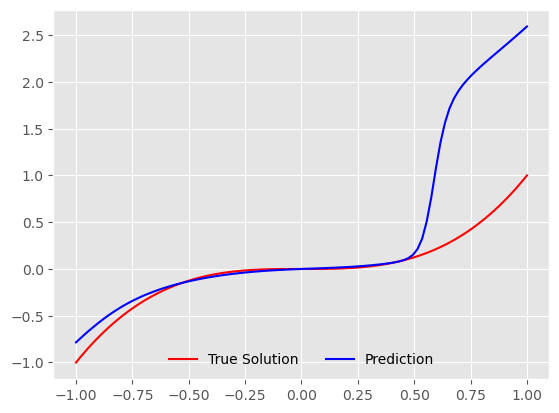

In [10]:
# True Solution (found analytically)
def true_solution(x):
    return x**3

X = np.linspace(-1, 1, 100)
result = []
for i in X:
    result.append(g(i).numpy()[0][0][0])
S = true_solution(X)

plt.plot(X, S, color = "red", label = "True Solution") # True solution
plt.plot(X, result, color = "blue", label = "Prediction") # Predicition
plt.legend(frameon=False, loc='lower center', ncol=2)
plt.show()